In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Reading and processing dataset 

In [3]:
dataset_root = 'datasets/nsl-kdd'

In [6]:
train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

In [7]:
# Original KDD dataset feature names obtained from 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [8]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [10]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open('datasets/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

## Generating and analyzing train and test sets

In [11]:
train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)
    
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

In [12]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

In [13]:
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

<Axes: ylabel='attack_type'>

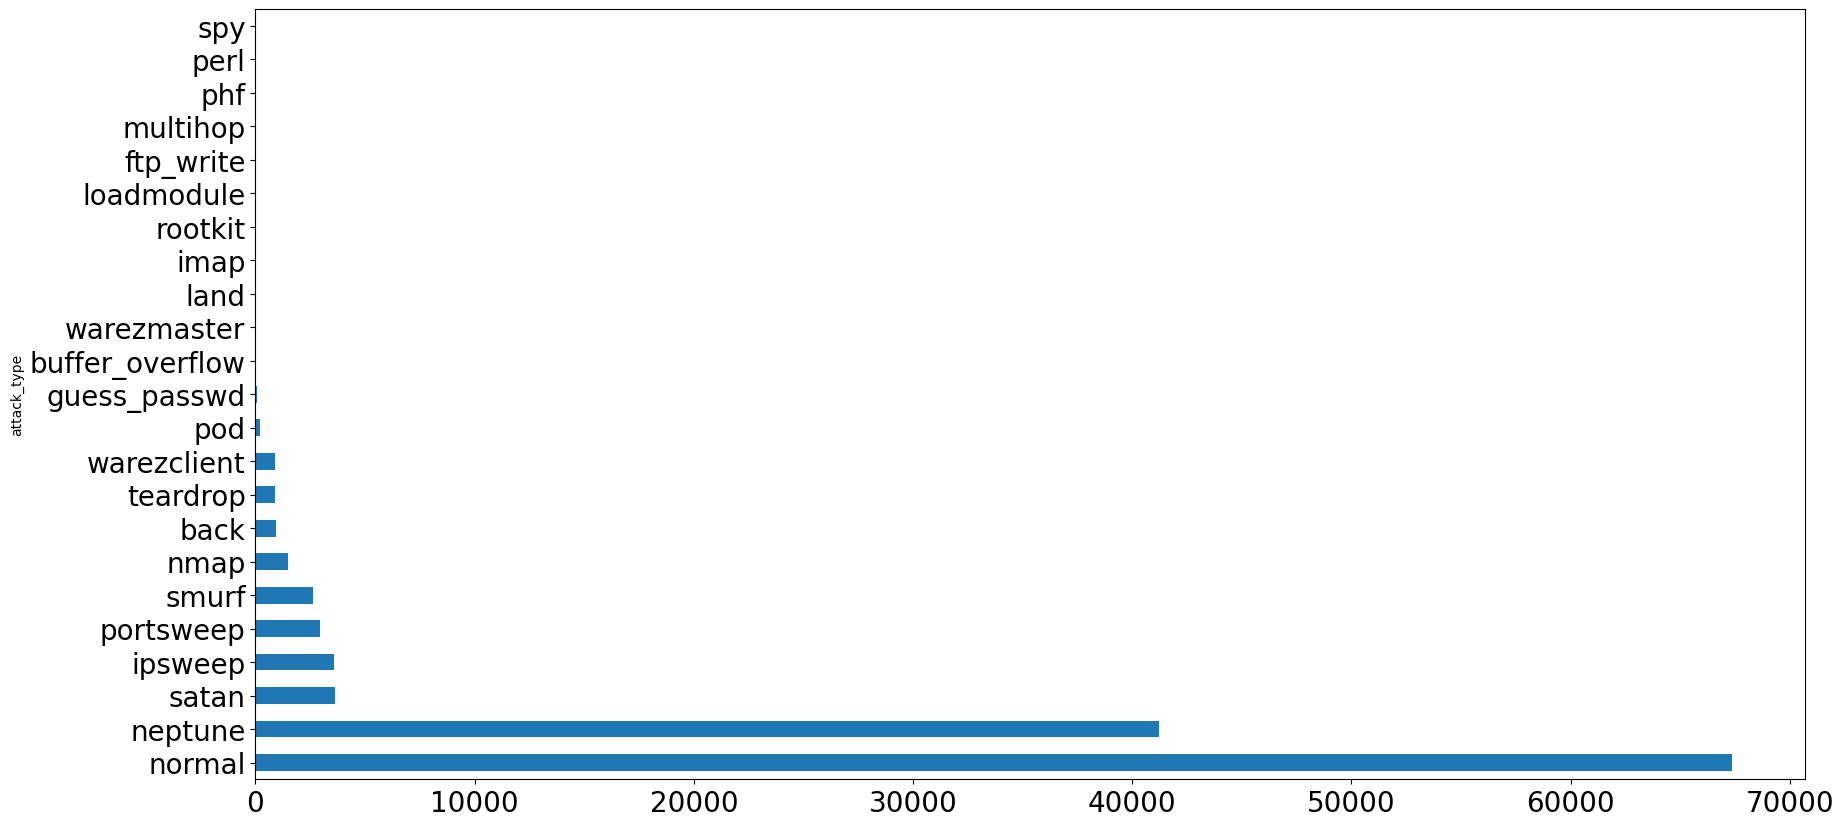

In [14]:
train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

<Axes: ylabel='attack_category'>

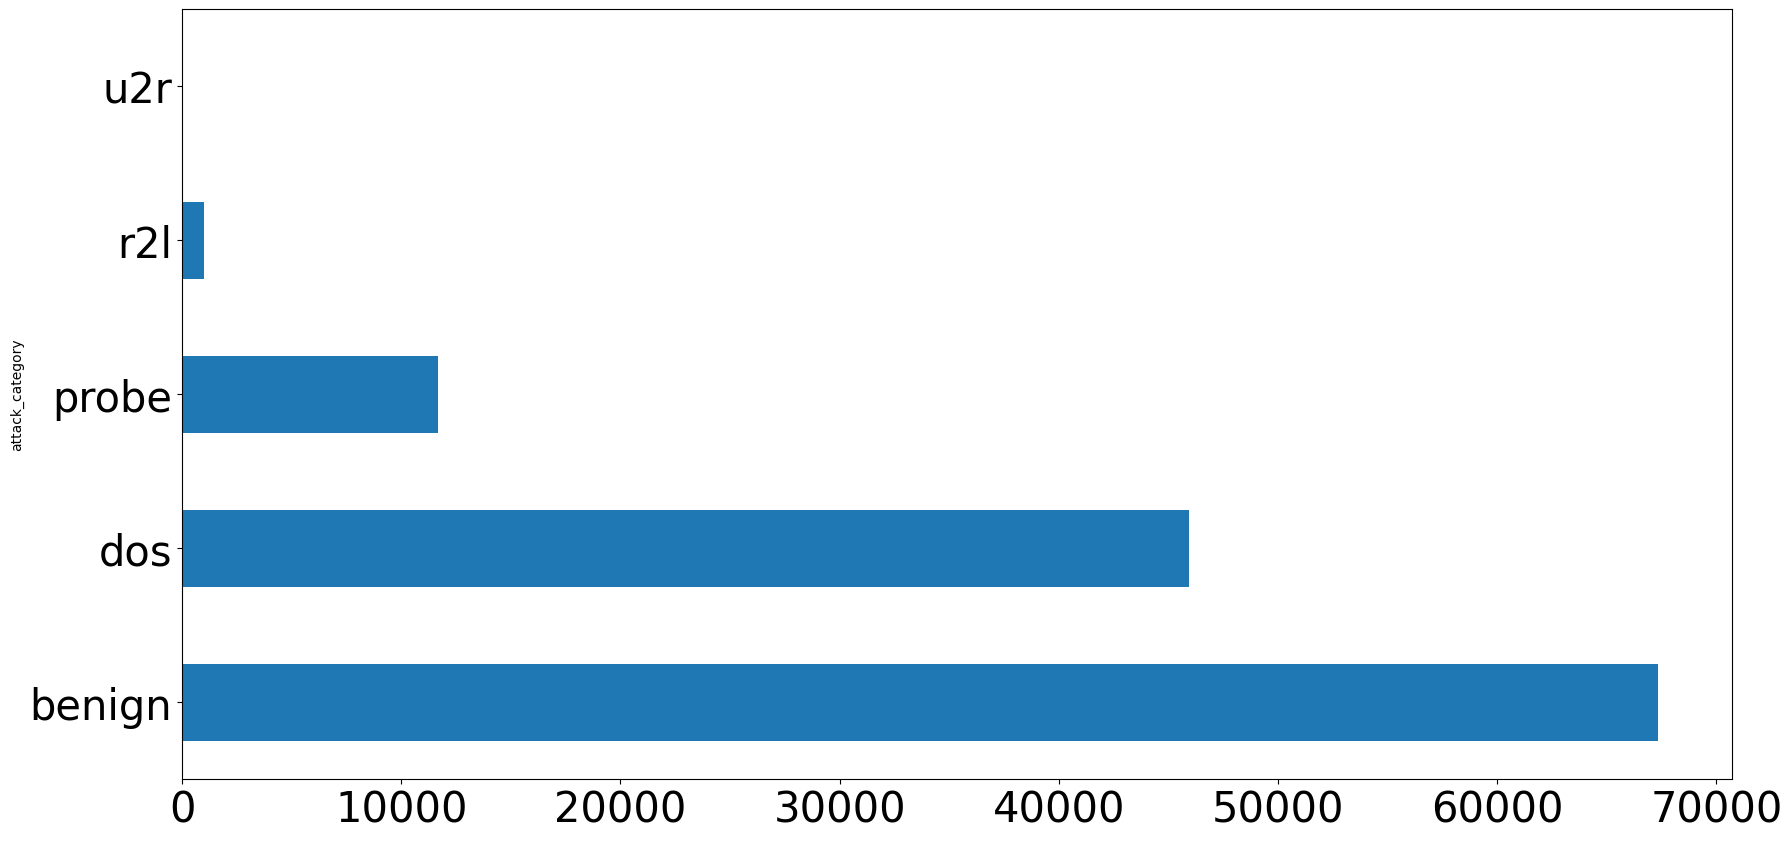

In [12]:
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

<Axes: ylabel='attack_type'>

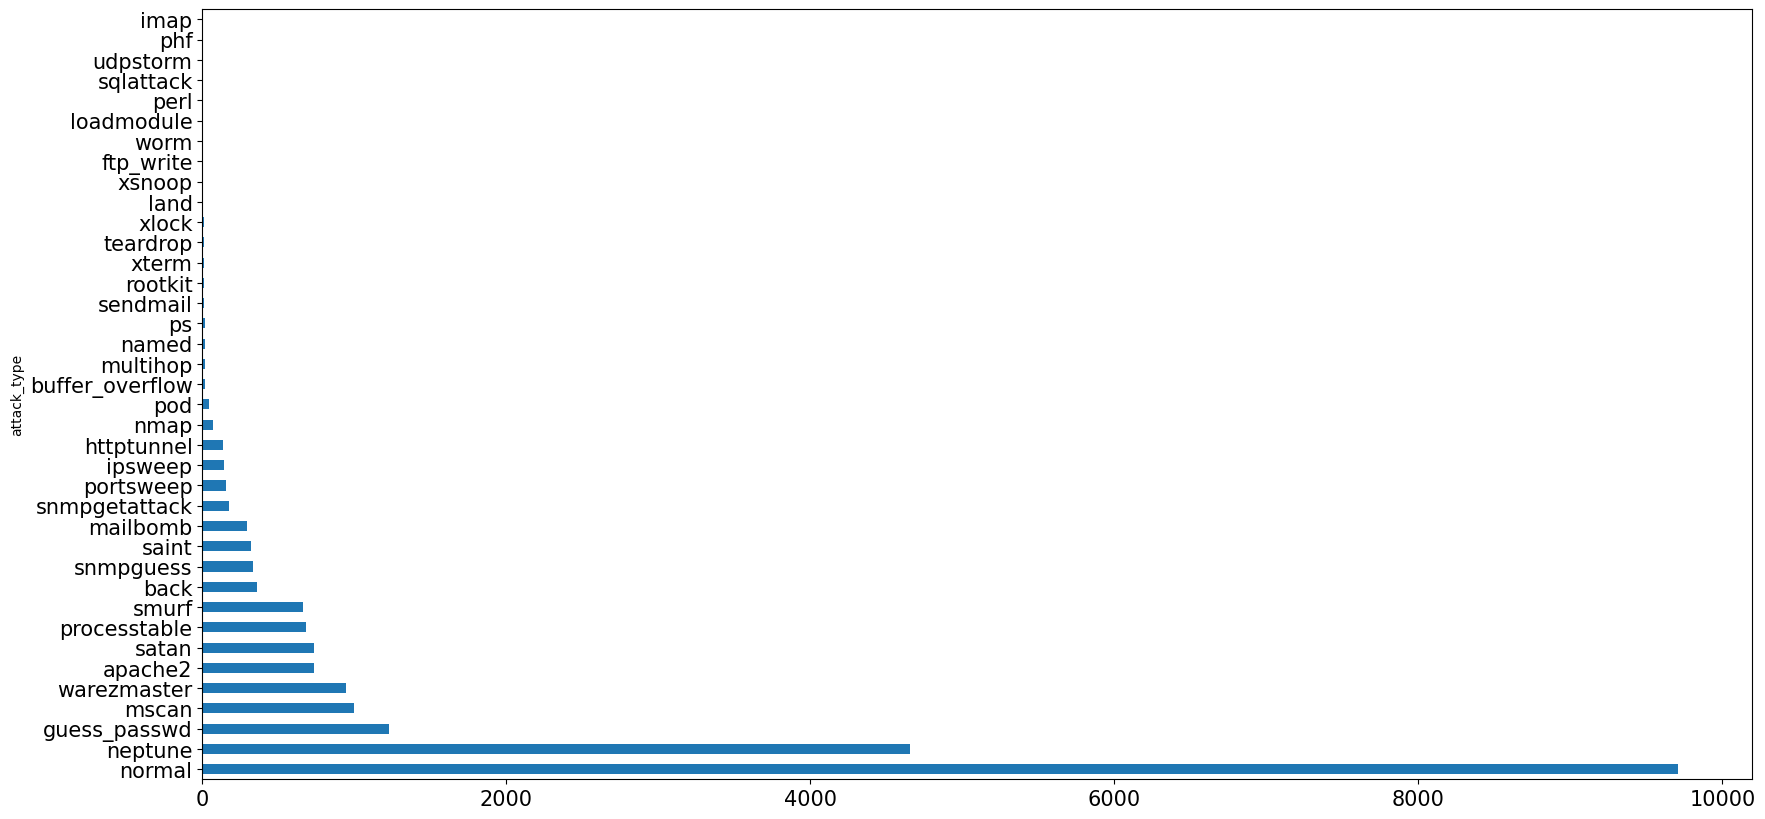

In [16]:
test_attack_types.plot(kind='barh', figsize=(20,10), fontsize=15)

<Axes: ylabel='attack_category'>

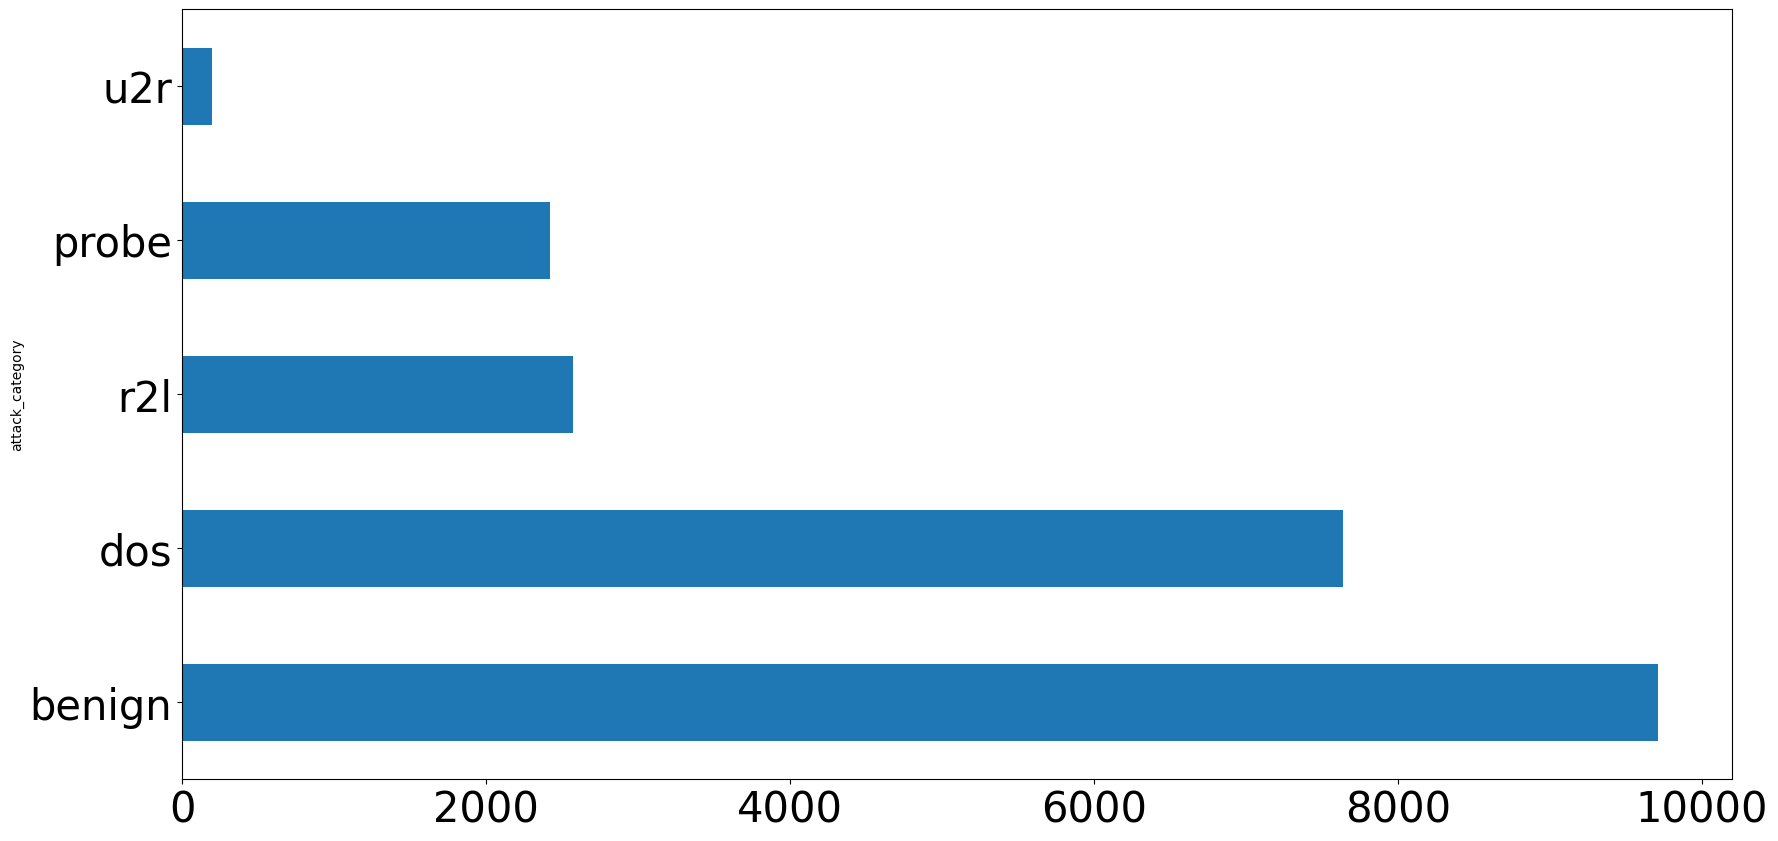

In [17]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

In [22]:
# Let's take a look at the binary features
# By definition, all of these features should have a min of 0.0 and a max of 1.0

train_df[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.0,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
logged_in,125973.0,0.395736,0.489010,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.001342,0.036603,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.000167,0.012910,0.0,0.0,0.0,0.0,1.0
is_host_login,125973.0,0.000008,0.002817,0.0,0.0,0.0,0.0,1.0
is_guest_login,125973.0,0.009423,0.096612,0.0,0.0,0.0,0.0,1.0


In [23]:
# Wait a minute... the su_attempted column has a max value of 2.0?

train_df.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

In [24]:
# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

In [25]:
# Next, we notice that the num_outbound_cmds column only takes on one value!

train_df.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    125973
dtype: int64

In [26]:
# Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

## Data preparation

In [27]:
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)

In [28]:
combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [31]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# Example statistics for the 'duration' feature before scaling
train_x['duration'].describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64

In [33]:
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    1.259730e+05
mean     2.549477e-17
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [34]:
# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [35]:
# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
dtype: float64

In [36]:
# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

In [37]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,...,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05
mean,2.549477e-17,-4.512349e-19,7.614590e-19,0.000198,4.230328e-19,4.455945e-18,-2.244894e-17,2.989431e-18,0.395736,-6.549957e-18,...,-1.756996e-17,-5.815290e-17,-1.215514e-16,-2.374624e-17,2.899184e-17,3.068398e-17,1.711873e-17,-2.631264e-17,4.907180e-17,7.749960e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,0.014086,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.489010,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,-1.836071e+00,-1.044721e+00,-1.161030e+00,-4.390782e-01,-4.801968e-01,-2.891034e-01,-6.395319e-01,-6.248708e-01,-3.876346e-01,-3.763870e-01
25%,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,-1.009507e+00,-9.543885e-01,-1.049659e+00,-4.390782e-01,-4.801968e-01,-2.891034e-01,-6.395319e-01,-6.248708e-01,-3.876346e-01,-3.763870e-01
50%,-1.102492e-01,-7.754745e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,7.343426e-01,-4.756270e-01,-2.504011e-02,-3.332138e-01,-4.801968e-01,-2.891034e-01,-6.395319e-01,-6.248708e-01,-3.876346e-01,-3.763870e-01
75%,-1.102492e-01,-7.715224e-03,-4.790326e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,1.000000,-1.166364e-02,...,7.343426e-01,1.258754e+00,1.066401e+00,-6.855302e-02,-2.860195e-01,-1.114257e-01,1.608759e+00,1.618955e+00,-3.876346e-01,-3.763870e-01
max,1.636428e+01,2.350675e+02,3.257486e+02,1.000000,1.174348e+01,2.088191e+02,3.571955e+01,1.104972e+02,1.000000,3.123689e+02,...,7.343426e-01,1.258754e+00,1.066401e+00,4.854138e+00,2.756092e+00,8.594782e+00,1.608759e+00,1.618955e+00,2.874410e+00,2.753914e+00


In [38]:
train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

In [39]:
train_Y.unique()


array(['benign', 'dos', 'r2l', 'probe', 'u2r'], dtype=object)

In [40]:
def Plot_Confusion_Matrix(train_Y):
    # Extract unique labels
    unique_labels = np.unique(train_Y)

    # Convert confusion matrix into a DataFrame for better visualization
    df_cm = pd.DataFrame(results, index=unique_labels, columns=unique_labels)

    # Plotting the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("Error Rate:", error)

In [46]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming 'results' is your confusion matrix and 'unique_labels' contains your class labels
def calculate_metrics(cm, labels):
    metrics = {}
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fpr = FP / (FP + TN)
    g_score = np.sqrt(precision * recall)
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    for i, label in enumerate(labels):
        metrics[label] = {
            'Precision': precision[i],
            'Recall': recall[i],
            'F1 Score': f1_score[i],
            'FPR': fpr[i],
            'G-Score': g_score[i],
            'MCC': mcc[i]
        }
    
    #return metrics, accuracy_score(test_Y, pred_y)
    # Print metrics in an elegant way
    print("Classification Metrics per Class:")
    for label, metric in metrics.items():
        print(f"\nMetrics for {label}:")
        for metric_name, value in metric.items():
            print(f"  {metric_name}: {value:.4f}")
    overall_accuracy = np.diag(cm).sum() / cm.sum()

    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")




[[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]
0.2378903477643719


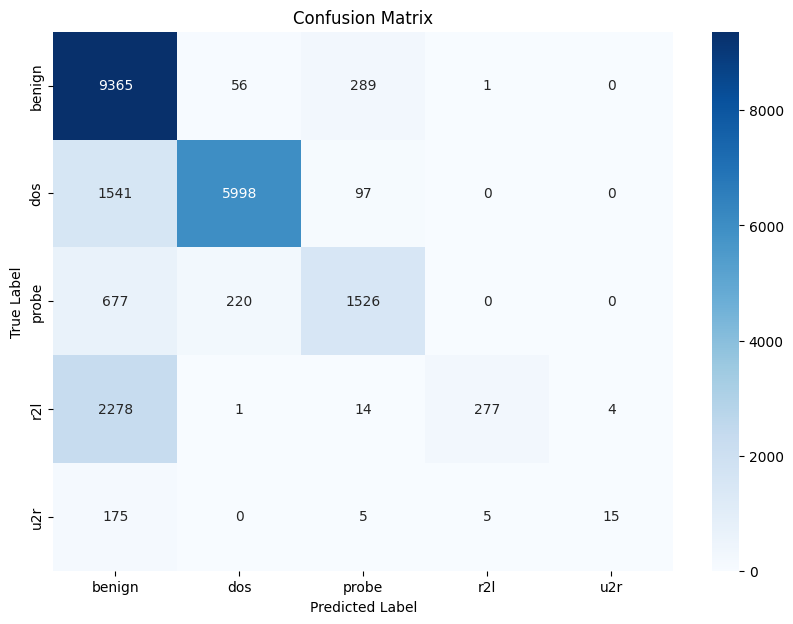

Error Rate: 0.2378903477643719
Classification Metrics per Class:

Metrics for benign:
  Precision: 0.6672
  Recall: 0.9644
  F1 Score: 0.7887
  FPR: 0.3640
  G-Score: 0.8021
  MCC: 0.6133

Metrics for dos:
  Precision: 0.9559
  Recall: 0.7855
  F1 Score: 0.8623
  FPR: 0.0186
  G-Score: 0.8665
  MCC: 0.8098

Metrics for r2l:
  Precision: 0.7903
  Recall: 0.6298
  F1 Score: 0.7010
  FPR: 0.0201
  G-Score: 0.7055
  MCC: 0.6747

Metrics for probe:
  Precision: 0.9788
  Recall: 0.1076
  F1 Score: 0.1939
  FPR: 0.0003
  G-Score: 0.3246
  MCC: 0.3065

Metrics for u2r:
  Precision: 0.7895
  Recall: 0.0750
  F1 Score: 0.1370
  FPR: 0.0002
  G-Score: 0.2433
  MCC: 0.2418

Overall Accuracy: 0.7621
              precision    recall  f1-score   support

      benign       0.67      0.96      0.79      9711
         dos       0.96      0.79      0.86      7636
         r2l       0.79      0.63      0.70      2423
       probe       0.98      0.11      0.19      2574
         u2r       0.79      0.07

In [49]:
# 5-class classification version
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

classifier = DecisionTreeClassifier(random_state=17)
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)
Plot_Confusion_Matrix(train_Y)

# Calculate metrics
calculate_metrics(results, train_Y.unique())
report = classification_report(test_Y, pred_y, target_names=train_Y.unique())
print(report)



In [ ]:
#For Class 1:
#TP (True Positives): 9365 (correctly predicted as Class 1)
#FP (False Positives): 1541 + 677 + 2278 + 175 = 5671 (other classes incorrectly predicted as Class 1)
#FN (False Negatives): 56 + 289 + 1 + 0 = 346 (Class 1 instances incorrectly predicted as other classes)
#TN (True Negatives): Total - TP - FP - FN for Class 1

[[9457   57  193    2    2]
 [1675 5894   67    0    0]
 [ 670  156 1597    0    0]
 [2369    2   37  126   40]
 [ 176    0    4    7   13]]
0.24205997161107173


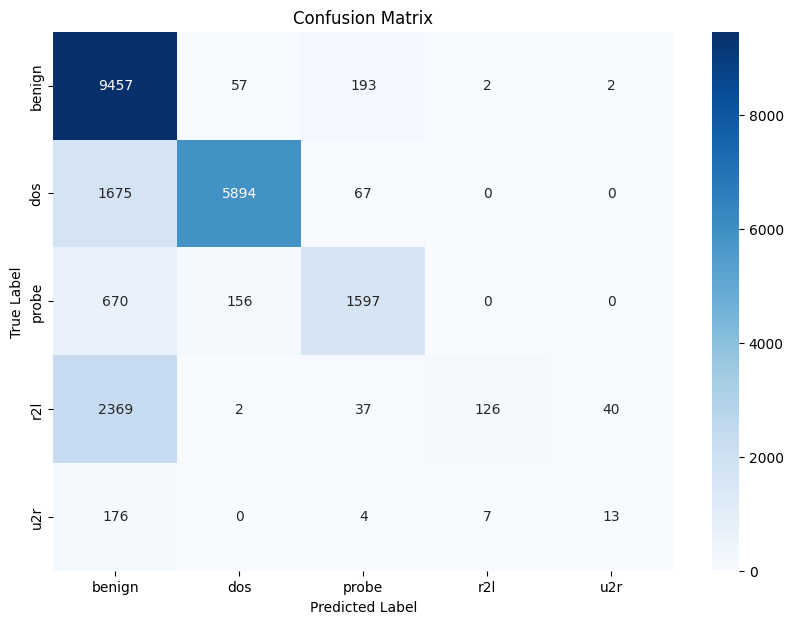

Error Rate: 0.24205997161107173
Classification Metrics per Class:

Metrics for benign:
  Precision: 0.6592
  Recall: 0.9738
  F1 Score: 0.7862
  FPR: 0.3810
  G-Score: 0.8012
  MCC: 0.6102

Metrics for dos:
  Precision: 0.9648
  Recall: 0.7719
  F1 Score: 0.8576
  FPR: 0.0144
  G-Score: 0.8630
  MCC: 0.8065

Metrics for r2l:
  Precision: 0.8414
  Recall: 0.6591
  F1 Score: 0.7392
  FPR: 0.0150
  G-Score: 0.7447
  MCC: 0.7185

Metrics for probe:
  Precision: 0.9333
  Recall: 0.0490
  F1 Score: 0.0930
  FPR: 0.0005
  G-Score: 0.2137
  MCC: 0.1999

Metrics for u2r:
  Precision: 0.2364
  Recall: 0.0650
  F1 Score: 0.1020
  FPR: 0.0019
  G-Score: 0.1240
  MCC: 0.1200

Overall Accuracy: 0.7579
              precision    recall  f1-score   support

      benign       0.66      0.97      0.79      9711
         dos       0.96      0.77      0.86      7636
         r2l       0.84      0.66      0.74      2423
       probe       0.93      0.05      0.09      2574
         u2r       0.24      0.0

In [50]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)
Plot_Confusion_Matrix(train_Y)

# Calculate metrics
calculate_metrics(results, train_Y.unique())

report = classification_report(test_Y, pred_y, target_names=train_Y.unique())
print(report)


[[9008  292  407    3    1]
 [1972 5654   10    0    0]
 [ 714  122 1500   87    0]
 [2471    2    1  100    0]
 [ 181    2    1    4   12]]
0.2781227821149752


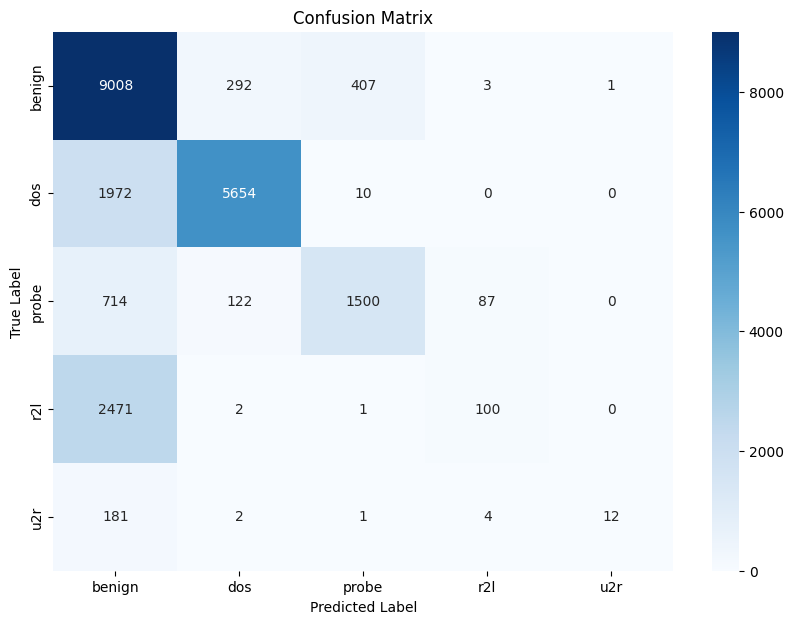

Error Rate: 0.2781227821149752
Classification Metrics per Class:

Metrics for benign:
  Precision: 0.6279
  Recall: 0.9276
  F1 Score: 0.7489
  FPR: 0.4160
  G-Score: 0.7632
  MCC: 0.5267

Metrics for dos:
  Precision: 0.9312
  Recall: 0.7404
  F1 Score: 0.8249
  FPR: 0.0280
  G-Score: 0.8303
  MCC: 0.7600

Metrics for r2l:
  Precision: 0.7817
  Recall: 0.6191
  F1 Score: 0.6909
  FPR: 0.0208
  G-Score: 0.6956
  MCC: 0.6640

Metrics for probe:
  Precision: 0.5155
  Recall: 0.0389
  F1 Score: 0.0723
  FPR: 0.0047
  G-Score: 0.1415
  MCC: 0.1176

Metrics for u2r:
  Precision: 0.9231
  Recall: 0.0600
  F1 Score: 0.1127
  FPR: 0.0000
  G-Score: 0.2353
  MCC: 0.2342

Overall Accuracy: 0.7219
              precision    recall  f1-score   support

      benign       0.63      0.93      0.75      9711
         dos       0.93      0.74      0.82      7636
         r2l       0.78      0.62      0.69      2423
       probe       0.52      0.04      0.07      2574
         u2r       0.92      0.06

In [51]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)
Plot_Confusion_Matrix(train_Y)

# Calculate metrics
calculate_metrics(results, train_Y.unique())

report = classification_report(test_Y, pred_y, target_names=train_Y.unique())
print(report)


## Dealing with class imbalance

In [53]:
test_Y.value_counts().apply(lambda x: x/float(len(test_Y)))

attack_category
benign    0.430758
dos       0.338715
r2l       0.114177
probe     0.107479
u2r       0.008872
Name: count, dtype: float64

In [54]:
train_Y.value_counts().apply(lambda x: x/float(len(train_Y)))

attack_category
benign    0.534583
dos       0.364578
probe     0.092528
r2l       0.007899
u2r       0.000413
Name: count, dtype: float64

In [55]:
print(pd.Series(train_Y).value_counts())

attack_category
benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64


In [58]:
from imblearn.over_sampling import SMOTE



In [59]:
# Initialize SMOTE with sampling_strategy and random_state
sm = SMOTE(sampling_strategy='auto', random_state=0)

# Apply SMOTE to your training data
train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)

# Print the value counts for each class after resampling
print(pd.Series(train_Y_sm).value_counts())

attack_category
benign    67343
dos       67343
r2l       67343
probe     67343
u2r       67343
Name: count, dtype: int64


In [60]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Calculate the mean class size
mean_class_size = int(pd.Series(train_Y).value_counts().sum() / 5)

# Define the sampling strategy
sampling_strategy = {'benign': mean_class_size,
                     'dos': mean_class_size,
                     'probe': mean_class_size,
                     'r2l': mean_class_size,
                     'u2r': mean_class_size}

# Initialize RandomUnderSampler with sampling_strategy, random_state, and replacement
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=0, replacement=True)

# Apply RandomUnderSampler to your data
train_x_rus, train_Y_rus = rus.fit_resample(train_x_sm, train_Y_sm)

# Print the value counts for each class after resampling
print(pd.Series(train_Y_rus).value_counts())


attack_category
benign    25194
dos       25194
probe     25194
r2l       25194
u2r       25194
Name: count, dtype: int64


[[8948   80  672    5    6]
 [1014 5733  889    0    0]
 [ 140  170 2080   32    1]
 [2235    0   98  213   28]
 [  56    0   83   24   37]]
0.245431156848829


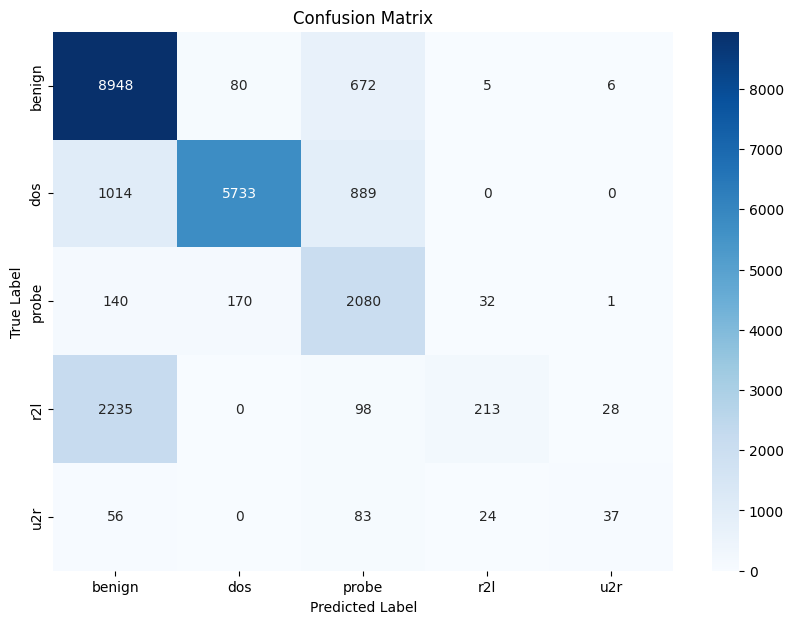

Error Rate: 0.245431156848829
Classification Metrics per Class:

Metrics for benign:
  Precision: 0.7220
  Recall: 0.9214
  F1 Score: 0.8096
  FPR: 0.2684
  G-Score: 0.8157
  MCC: 0.6499

Metrics for dos:
  Precision: 0.9582
  Recall: 0.7508
  F1 Score: 0.8419
  FPR: 0.0168
  G-Score: 0.8482
  MCC: 0.7868

Metrics for r2l:
  Precision: 0.5442
  Recall: 0.8584
  F1 Score: 0.6661
  FPR: 0.0866
  G-Score: 0.6835
  MCC: 0.6371

Metrics for probe:
  Precision: 0.7774
  Recall: 0.0828
  F1 Score: 0.1496
  FPR: 0.0031
  G-Score: 0.2536
  MCC: 0.2313

Metrics for u2r:
  Precision: 0.5139
  Recall: 0.1850
  F1 Score: 0.2721
  FPR: 0.0016
  G-Score: 0.3083
  MCC: 0.3049

Overall Accuracy: 0.7546
              precision    recall  f1-score   support

      benign       0.72      0.92      0.81      9711
         dos       0.96      0.75      0.84      7636
         r2l       0.54      0.86      0.67      2423
       probe       0.78      0.08      0.15      2574
         u2r       0.51      0.18 

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

classifier = DecisionTreeClassifier(random_state=17)
classifier.fit(train_x_rus, train_Y_rus)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)
Plot_Confusion_Matrix(train_Y)

# Calculate metrics
calculate_metrics(results, train_Y.unique())

report = classification_report(test_Y, pred_y, target_names=train_Y.unique())
print(report)


## Attempting unsupervised learning

In [63]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5).fit(train_x)
pred_y = kmeans.predict(test_x)

# Inspect the clustering results
print(pd.Series(pred_y).value_counts())

0    14212
3     5191
2     2031
1     1110
Name: count, dtype: int64


In [ ]:

#To evaluate our model, we compute how many benign samples are grouped into the same cluster, 
#and how many samples of other classes are grouped into that cluster. 
#Specifically, we compute two metrics, the completeness score and the homogeneity score. 
#A cluster is complete (has completeness score 1) if all data points belonging to the same class
#(i.e., with the same class label) are clustered together. 
#On the other hand, a cluster is homogeneous (has homogeneity score 1) if all data points that are clustered together 
#belong to the same class.
#The V-measure, defined to be the harmonic mean of homogeneity and completeness,
#provides a convenient single metric for evaluation:

#v_measure_score = 2 * (homogeneity * completeness) / (homogeneity + completeness)

                                                      

In [64]:
from sklearn.metrics import completeness_score,\
    homogeneity_score, v_measure_score

print('Completeness: {}'.format(completeness_score(test_Y, pred_y)))
print('Homogeneity: {}'.format(homogeneity_score(test_Y, pred_y)))
print('V-measure: {}'.format(v_measure_score(test_Y, pred_y)))

Completeness: 0.3488817353158169
Homogeneity: 0.27550214418166635
V-measure: 0.3078800375906104


In [65]:
print('Total number of features: {}'.format(len(train_x.columns)))


Total number of features: 118


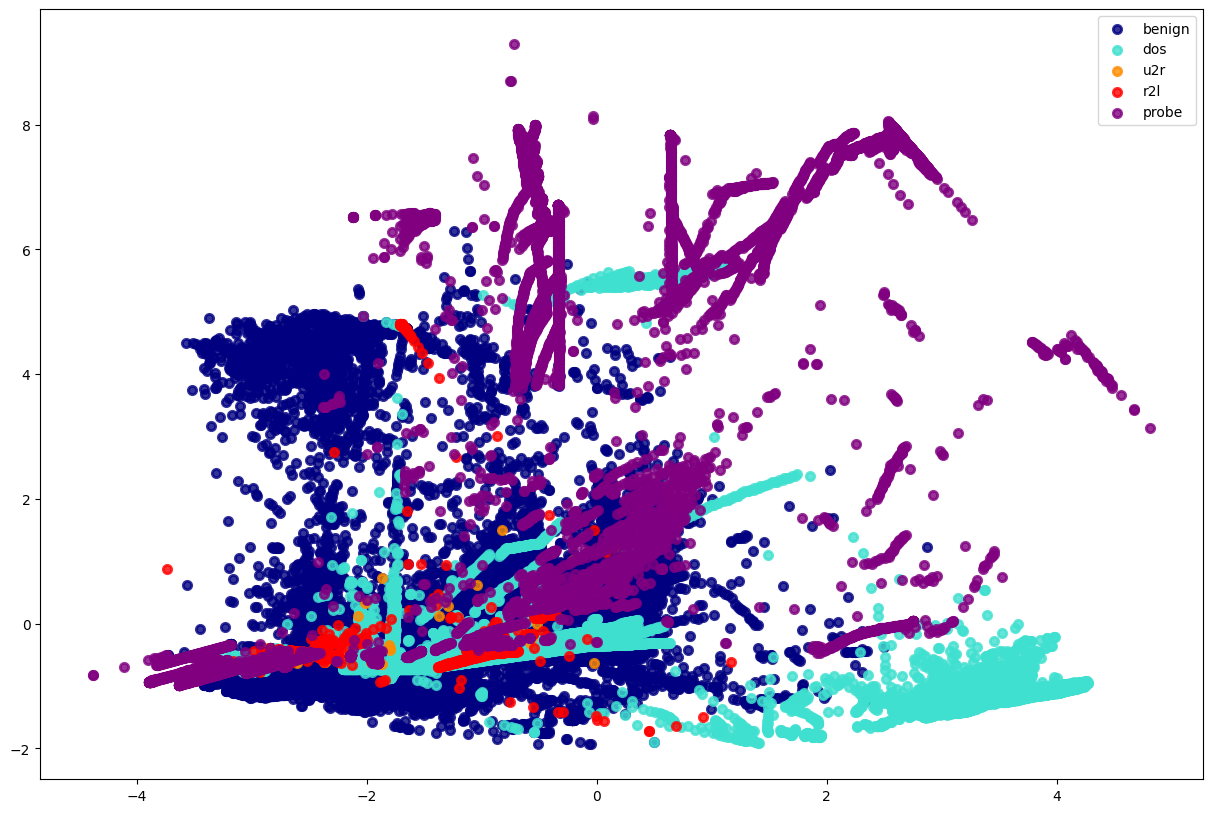

In [66]:
# First, let's visualize the dataset (only numeric cols)

from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality so we can visualize the dataset on a 2d plot
pca = PCA(n_components=2)
train_x_pca_cont = pca.fit_transform(train_x[numeric_cols])

plt.figure(figsize=(15,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, category.keys()):
    plt.scatter(train_x_pca_cont[train_Y==cat, 0], train_x_pca_cont[train_Y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

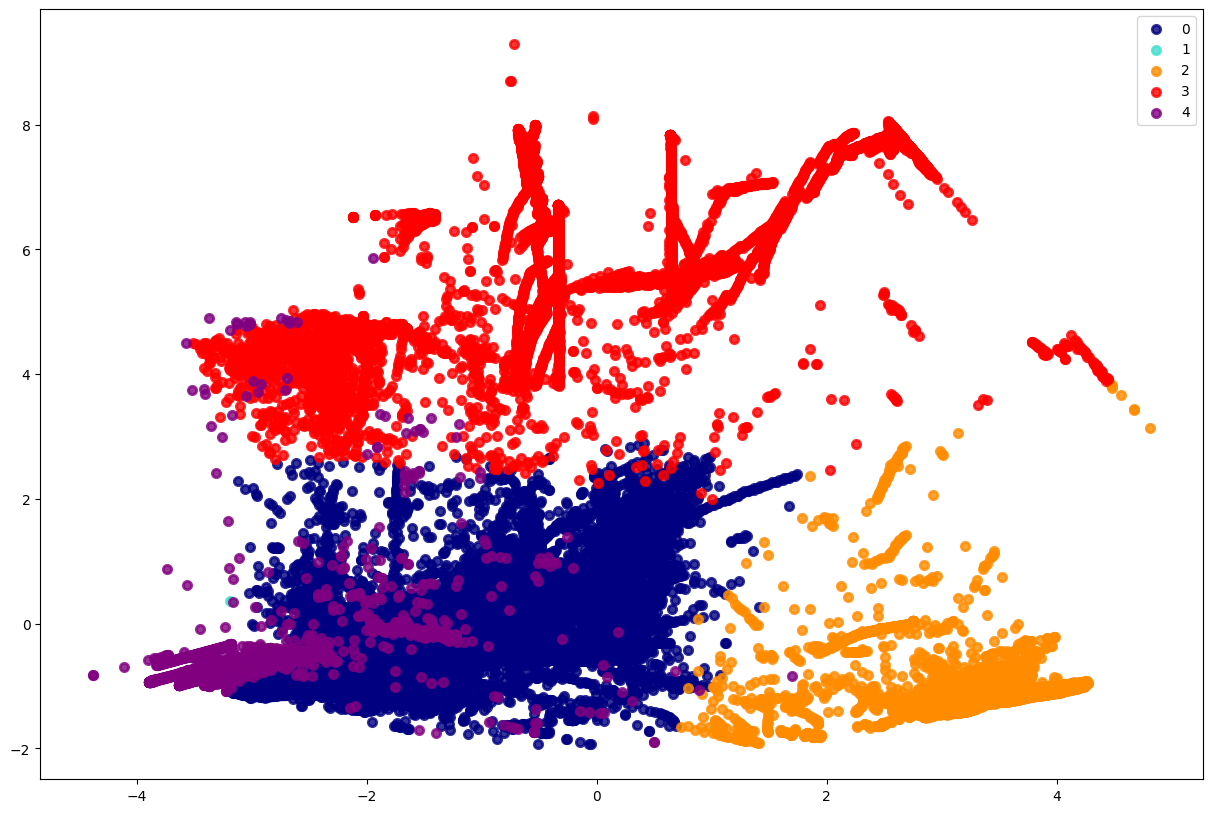

In [67]:
# Apply k-means (k=5, only using numeric cols) + PCA + plot

from sklearn.cluster import KMeans

# Fit the training data to a k-means clustering estimator model
kmeans = KMeans(n_clusters=5, random_state=17).fit(train_x[numeric_cols])

# Retrieve the labels assigned to each training sample
kmeans_y = kmeans.labels_

# Plot in 2d with train_x_pca_cont
plt.figure(figsize=(15,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, range(5)):
    plt.scatter(train_x_pca_cont[kmeans_y==cat, 0],
                train_x_pca_cont[kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

In [68]:
print('Total number of features: {}'.format(len(train_x.columns)))
print('Total number of continuous features: {}'.format(len(train_x[numeric_cols].columns)))

Total number of features: 118
Total number of continuous features: 31


In [69]:
from sklearn.metrics import completeness_score,\
    homogeneity_score, v_measure_score

print('Completeness: {}'.format(completeness_score(test_Y, pred_y)))
print('Homogeneity: {}'.format(homogeneity_score(test_Y, pred_y)))
print('V-measure: {}'.format(v_measure_score(test_Y, pred_y)))

Completeness: 0.3488817353158169
Homogeneity: 0.27550214418166635
V-measure: 0.3078800375906104


## Using "Attribute Ratio" (AR) feature selection

In [70]:
averages = train_df.loc[:, numeric_cols].mean()

In [71]:
averages_per_class = train_df[numeric_cols+['attack_category']].groupby('attack_category').mean()

In [72]:
AR = {}
for col in numeric_cols:
    AR[col] = max(averages_per_class[col])/averages[col]

In [73]:
AR

{'duration': 7.225829157212557,
 'src_bytes': 8.464064204948945,
 'dst_bytes': 9.154854355343401,
 'wrong_fragment': 2.742896335488928,
 'urgent': 173.03983516483518,
 'hot': 40.77451681709518,
 'num_failed_logins': 46.03855641845592,
 'num_compromised': 4.338539274983927,
 'num_root': 2.6091432537726016,
 'num_file_creations': 62.23362492770388,
 'num_shells': 326.11353550295854,
 'num_access_files': 4.694879248658319,
 'count': 2.1174082949142403,
 'srv_count': 1.1773191099992069,
 'serror_rate': 2.6310546426370274,
 'srv_serror_rate': 2.6432463184901596,
 'rerror_rate': 3.645586087828456,
 'srv_rerror_rate': 3.6677418023254273,
 'same_srv_rate': 1.5079612006047387,
 'diff_srv_rate': 4.069085485070197,
 'srv_diff_host_rate': 3.0815657101103833,
 'dst_host_count': 1.3428596865228266,
 'dst_host_srv_count': 1.6453161847397422,
 'dst_host_same_srv_rate': 1.5575788279743736,
 'dst_host_diff_srv_rate': 4.8373418489739075,
 'dst_host_same_src_port_rate': 4.393080378884036,
 'dst_host_srv_d

In [74]:
def binary_AR(df, col):
    series_zero = train_df[train_df[col] == 0].groupby('attack_category').size()
    series_one = train_df[train_df[col] == 1].groupby('attack_category').size()
    return max(series_one/series_zero)

In [75]:
# Recreating dataframes with 2-class and 5-class labels

labels2 = ['normal', 'attack']
labels5 = ['normal', 'dos', 'probe', 'r2l', 'u2r']

train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)
    
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

In [76]:
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)

In [77]:
train_df['labels2'] = train_df.apply(lambda x: 'normal' if 'normal' in x['attack_type'] else 'attack', axis=1)
test_df['labels2'] = test_df.apply(lambda x: 'normal' if 'normal' in x['attack_type'] else 'attack', axis=1)

combined_df = pd.concat([train_df, test_df])
original_cols = combined_df.columns

combined_df = pd.get_dummies(combined_df, columns=nominal_cols, drop_first=True)

added_cols = set(combined_df.columns) - set(original_cols)
added_cols= list(added_cols)

In [78]:
combined_df.attack_category = pd.Categorical(combined_df.attack_category)
combined_df.labels2 = pd.Categorical(combined_df.labels2)

combined_df['labels5'] = combined_df['attack_category'].cat.codes
combined_df['labels2'] = combined_df['labels2'].cat.codes

In [79]:
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

In [80]:
for col in binary_cols+dummy_variables:
    cur_AR = binary_AR(train_df, col)
    if cur_AR:
        AR[col] = cur_AR

In [81]:
train_df[train_df.service_Z39_50 == 1].groupby('attack_category').size()

attack_category
benign      0
dos       851
probe      11
r2l         0
u2r         0
dtype: int64

In [82]:
len(binary_cols+added_cols)

87

In [83]:
import operator
AR = dict((k, v) for k,v in AR.items() if not np.isnan(v))
sorted_AR = sorted(AR.items(), key=lambda x:x[1], reverse=True)

In [84]:
sorted_AR

[('protocol_type_tcp', inf),
 ('num_shells', 326.11353550295854),
 ('urgent', 173.03983516483518),
 ('num_file_creations', 62.23362492770388),
 ('flag_SF', 51.0),
 ('num_failed_logins', 46.03855641845592),
 ('hot', 40.77451681709518),
 ('logged_in', 10.569767441860465),
 ('dst_bytes', 9.154854355343401),
 ('src_bytes', 8.464064204948945),
 ('duration', 7.225829157212557),
 ('dst_host_srv_diff_host_rate', 5.756880682756422),
 ('dst_host_diff_srv_rate', 4.8373418489739075),
 ('num_access_files', 4.694879248658319),
 ('dst_host_same_src_port_rate', 4.393080378884036),
 ('num_compromised', 4.338539274983927),
 ('diff_srv_rate', 4.069085485070197),
 ('dst_host_srv_rerror_rate', 3.66792052796591),
 ('srv_rerror_rate', 3.6677418023254273),
 ('rerror_rate', 3.645586087828456),
 ('dst_host_rerror_rate', 3.2795669242444374),
 ('srv_diff_host_rate', 3.0815657101103833),
 ('flag_S0', 2.965034965034965),
 ('wrong_fragment', 2.742896335488928),
 ('dst_host_srv_serror_rate', 2.673159595714105),
 ('sr

In [85]:
# Only keep features with AR value >= 0.01

features_to_use = []
for x,y in sorted_AR:
    if y >= 0.01:
        features_to_use.append(x)
        
features_to_use

['protocol_type_tcp',
 'num_shells',
 'urgent',
 'num_file_creations',
 'flag_SF',
 'num_failed_logins',
 'hot',
 'logged_in',
 'dst_bytes',
 'src_bytes',
 'duration',
 'dst_host_srv_diff_host_rate',
 'dst_host_diff_srv_rate',
 'num_access_files',
 'dst_host_same_src_port_rate',
 'num_compromised',
 'diff_srv_rate',
 'dst_host_srv_rerror_rate',
 'srv_rerror_rate',
 'rerror_rate',
 'dst_host_rerror_rate',
 'srv_diff_host_rate',
 'flag_S0',
 'wrong_fragment',
 'dst_host_srv_serror_rate',
 'srv_serror_rate',
 'serror_rate',
 'dst_host_serror_rate',
 'num_root',
 'count',
 'service_telnet',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'service_ftp_data',
 'same_srv_rate',
 'dst_host_count',
 'service_http',
 'srv_count',
 'root_shell',
 'service_private',
 'service_eco_i',
 'is_guest_login',
 'service_ftp',
 'flag_REJ',
 'flag_RSTR',
 'protocol_type_udp',
 'service_other',
 'service_domain_u',
 'service_smtp',
 'service_ecr_i',
 'flag_RSTO',
 'service_finger',
 'flag_SH',
 'service_Z

In [86]:
len(features_to_use)

76

In [87]:
len(sorted_AR) - len(features_to_use)

42

In [88]:
train_df_trimmed = train_df[features_to_use]
test_df_trimmed = test_df[features_to_use]

In [89]:
numeric_cols_to_use = list(set(numeric_cols).intersection(features_to_use))

In [90]:
# Rescaling is necessary after reducing dimensions

standard_scaler = StandardScaler()

train_df_trimmed[numeric_cols_to_use] = standard_scaler.fit_transform(train_df_trimmed[numeric_cols_to_use])
test_df_trimmed[numeric_cols_to_use] = standard_scaler.transform(test_df_trimmed[numeric_cols_to_use])

## Applying advanced ensembling

In [91]:
kmeans = KMeans(n_clusters=8, random_state=17)
kmeans.fit(train_df_trimmed[numeric_cols_to_use])
kmeans_train_y = kmeans.labels_

In [92]:
pd.crosstab(kmeans_train_y, train_Y_bin)

attack_category,0,1
row_0,,
0,4205,2798
1,601,4335
2,108,34385
3,3574,2314
4,519,288
5,2789,12099
6,55546,2411
7,1,0


In [93]:
train_df['kmeans_y'] = kmeans_train_y
train_df_trimmed['kmeans_y'] = kmeans_train_y

In [94]:
kmeans_test_y = kmeans.predict(test_df_trimmed[numeric_cols_to_use])
test_df['kmeans_y'] = kmeans_test_y

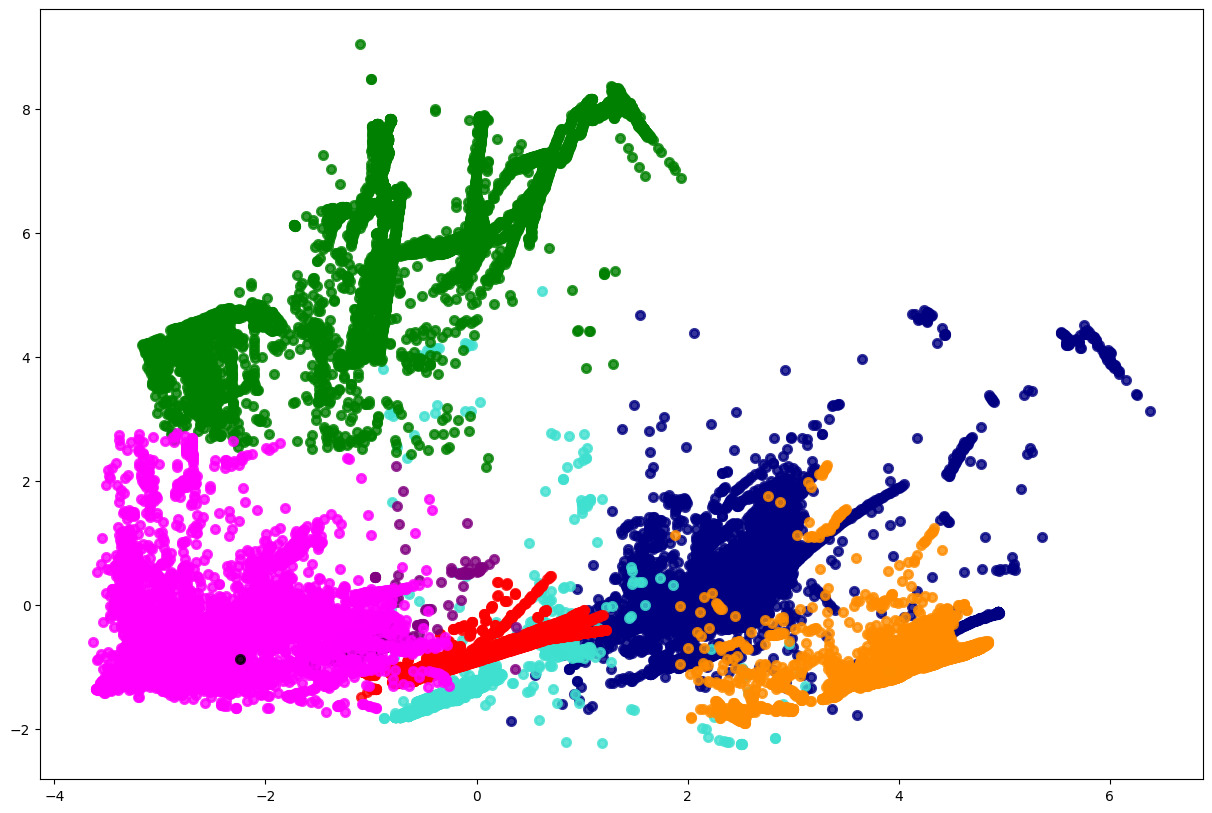

In [95]:
pca8 = PCA(n_components=2)
train_df_trimmed_pca8 = pca8.fit_transform(train_df_trimmed)

plt.figure(figsize=(15,10))

colors8 = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'magenta', 'black']
labels8 = [0,1,2,3,4,5,6,7]

for color, cat in zip(colors8, labels8):
    plt.scatter(train_df_trimmed_pca8[train_df.kmeans_y==cat, 0], train_df_trimmed_pca8[train_df.kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)

In [69]:
pd.crosstab(test_df.kmeans_y, test_df.labels2)

labels2,0,1
kmeans_y,,
0,4795,9515
1,5131,87
2,1997,6
4,427,51
5,1,10
6,8,37
7,474,5


In [96]:
# Ensembling strategy

# 1.	For clusters that have an aggregate size of fewer than 200 samples, we consider them outliers and assign them the attack label.

# 2.	For clusters with more than 95% of samples belonging to a single class, (either attack or benign) we assign the dominant label to the entire cluster.

# 3.	For each of the remaining clusters, we train a separate random forest classifier

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Cluster 0 - Random Forest Classifier (Strategy Option 3)

In [98]:
train_y0 = train_df[train_df.kmeans_y==0]
test_y0 = test_df[test_df.kmeans_y==0]
rfc = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=17).fit(train_y0.drop(['labels2', 'labels5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1), train_y0['labels2'])
pred_y0 = rfc.predict(test_y0.drop(['labels2', 'labels5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1))
print("cluster {} score is {}, {}".format(0, accuracy_score(pred_y0, test_y0['labels2']), accuracy_score(pred_y0, test_y0['labels2'], normalize=False)))

print(confusion_matrix(test_y0['labels2'], pred_y0))

cluster 0 score is 0.4909847434119279, 708
[[586 552]
 [182 122]]


### Cluster 1 - Dominant Label Zero (Strategy Option 2)

In [73]:
print(confusion_matrix(test_df[test_df.kmeans_y==1]['labels2'], np.zeros(len(test_df[test_df.kmeans_y==1]))))

[[5131    0]
 [  87    0]]


### Cluster 2 - Dominant Label Zero (Strategy Option 2)

In [74]:
print(confusion_matrix(test_df[test_df.kmeans_y==2]['labels2'], np.zeros(len(test_df[test_df.kmeans_y==2]))))

[[1997    0]
 [   6    0]]


### Cluster 3 - Empty Cluster

### Cluster 4 - Random Forest Classifier (Strategy Option 3)

In [99]:
train_y0 = train_df[train_df.kmeans_y==4]
test_y0 = test_df[test_df.kmeans_y==4]
rfc = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=17).fit(train_y0.drop(['labels2', 'labels5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1), train_y0['labels2'])
pred_y0 = rfc.predict(test_y0.drop(['labels2', 'labels5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1))
print("cluster {} score is {}, {}".format(4, accuracy_score(pred_y0, test_y0['labels2']), accuracy_score(pred_y0, test_y0['labels2'], normalize=False)))

print(confusion_matrix(test_y0['labels2'], pred_y0))

cluster 4 score is 1.0, 9
[[9]]


### Cluster 5 - Outlier/Attack (Strategy Option 1)

In [76]:
print(confusion_matrix(test_df[test_df.kmeans_y==5]['labels2'], np.ones(len(test_df[test_df.kmeans_y==5]))))

[[ 0  1]
 [ 0 10]]


### Cluster 6 - Outlier/Attack (Strategy Option 1)

In [77]:
print(confusion_matrix(test_df[test_df.kmeans_y==6]['labels2'], np.ones(len(test_df[test_df.kmeans_y==6]))))

[[ 0  8]
 [ 0 37]]


### Cluster 7 - Dominant Label Zero (Strategy Option 2)

In [78]:
print(confusion_matrix(test_df[test_df.kmeans_y==7]['labels2'], np.zeros(len(test_df[test_df.kmeans_y==7]))))

[[474   0]
 [  5   0]]


### Combined Results: k-means + Random Forest Classifier ensembling with AR feature selection

In [79]:
# combined results:
num_samples = 22544
false_pos = 3177 + 22 + 1 + 8
false_neg = 152 + 87 + 6 + 11 + 5

print('True positive %: {}'.format(1-(false_pos/num_samples)))
print('True negative %: {}'.format(1-(false_neg/num_samples)))

True positive %: 0.8577004968062456
True negative %: 0.9884226401703335
